In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!nvidia-smi

Fri May 24 05:30:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Directories
data_dir = '/content/drive/MyDrive/Colab/112-2-DLA/final/data'
data_dir

'/content/drive/MyDrive/Colab/112-2-DLA/final/data'

In [6]:
config = {
    'train_ratio': 0.8,
    'valid_ratio': 0.1,
    'test_ratio': 0.1,
    'batch_size': 64,
    'num_epochs': 30,
}

In [7]:
# Data transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, data_transforms)
full_dataset

Dataset ImageFolder
    Number of datapoints: 5250
    Root location: /content/drive/MyDrive/Colab/112-2-DLA/final/data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import DataLoader, Subset

# Assuming full_dataset is a torchvision dataset or similar
targets = np.array(full_dataset.targets)  # Extract the target labels

# Define the split ratios
train_ratio, val_ratio = config['train_ratio'], config['valid_ratio']
test_ratio = 1 - train_ratio - val_ratio

# First stratified split to get training set and temporary set (validation + test)
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=42)
train_idx, temp_idx = next(sss_train.split(np.zeros(len(targets)), targets))

# Extract the targets for the temporary set
temp_targets = targets[temp_idx]

# Second stratified split to split the temporary set into validation and test sets
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=620)
val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_targets)), temp_targets))

# Map the indices back to the original dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create the Subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

# Dataloaders and dataset sizes
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Class names
class_names = full_dataset.classes
class_names

['battery',
 'glass',
 'metal',
 'normal plastic',
 'paper',
 'paper container',
 'plastic bottle']

In [9]:
# Model
from torchvision.models import VGG16_Weights

model = models.vgg16(weights=VGG16_Weights.DEFAULT)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 175MB/s]


In [10]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = model.state_dict()
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print(f'Best val Acc: {best_val_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Train model
model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=config['num_epochs'])


Epoch 0/29


train Loss: 0.9625 Acc: 0.6548


val Loss: 0.5217 Acc: 0.8190
Epoch 1/29


train Loss: 0.4799 Acc: 0.8345


val Loss: 0.4575 Acc: 0.8362
Epoch 2/29


train Loss: 0.4089 Acc: 0.8567


val Loss: 0.3592 Acc: 0.8705
Epoch 3/29


train Loss: 0.3481 Acc: 0.8740


val Loss: 0.3351 Acc: 0.8914
Epoch 4/29


train Loss: 0.3326 Acc: 0.8857


val Loss: 0.2956 Acc: 0.8933
Epoch 5/29


train Loss: 0.2751 Acc: 0.9071


val Loss: 0.3123 Acc: 0.8990
Epoch 6/29


train Loss: 0.2713 Acc: 0.9048


val Loss: 0.2699 Acc: 0.9105
Epoch 7/29


train Loss: 0.2331 Acc: 0.9200


val Loss: 0.3125 Acc: 0.8971
Epoch 8/29


train Loss: 0.2253 Acc: 0.9260


val Loss: 0.2449 Acc: 0.9067
Epoch 9/29


train Loss: 0.1913 Acc: 0.9333


val Loss: 0.1948 Acc: 0.9448
Epoch 10/29


train Loss: 0.1935 Acc: 0.9321


val Loss: 0.2567 Acc: 0.9200
Epoch 11/29


train Loss: 0.1898 Acc: 0.9324


val Loss: 0.2370 Acc: 0.9181
Epoch 12/29


train Loss: 0.1810 Acc: 0.9298


val Loss: 0.2213 Acc: 0.9371
Epoch 13/29


train Loss: 0.1875 Acc: 0.9307


val Loss: 0.2082 Acc: 0.9200
Epoch 14/29


train Loss: 0.1555 Acc: 0.9462


val Loss: 0.2339 Acc: 0.9219
Epoch 15/29


train Loss: 0.1644 Acc: 0.9464


val Loss: 0.2287 Acc: 0.9257
Epoch 16/29


train Loss: 0.1741 Acc: 0.9419


val Loss: 0.2126 Acc: 0.9295
Epoch 17/29


train Loss: 0.1350 Acc: 0.9545


val Loss: 0.1860 Acc: 0.9314
Epoch 18/29


train Loss: 0.1453 Acc: 0.9500


val Loss: 0.2230 Acc: 0.9314
Epoch 19/29


train Loss: 0.1343 Acc: 0.9529


val Loss: 0.1987 Acc: 0.9371
Epoch 20/29


train Loss: 0.1494 Acc: 0.9464


val Loss: 0.2781 Acc: 0.9124
Epoch 21/29


train Loss: 0.1304 Acc: 0.9510


val Loss: 0.1631 Acc: 0.9448
Epoch 22/29


train Loss: 0.1408 Acc: 0.9486


val Loss: 0.2062 Acc: 0.9352
Epoch 23/29


train Loss: 0.1308 Acc: 0.9557


val Loss: 0.2168 Acc: 0.9219
Epoch 24/29


train Loss: 0.1241 Acc: 0.9576


val Loss: 0.2463 Acc: 0.9238
Epoch 25/29


train Loss: 0.1132 Acc: 0.9598


val Loss: 0.1860 Acc: 0.9467
Epoch 26/29


train Loss: 0.1235 Acc: 0.9586


val Loss: 0.2388 Acc: 0.9219
Epoch 27/29


train Loss: 0.1098 Acc: 0.9624


val Loss: 0.2095 Acc: 0.9257
Epoch 28/29


train Loss: 0.1129 Acc: 0.9624


val Loss: 0.1776 Acc: 0.9390
Epoch 29/29


train Loss: 0.1160 Acc: 0.9564


val Loss: 0.1778 Acc: 0.9276
Best val Acc: 0.9467


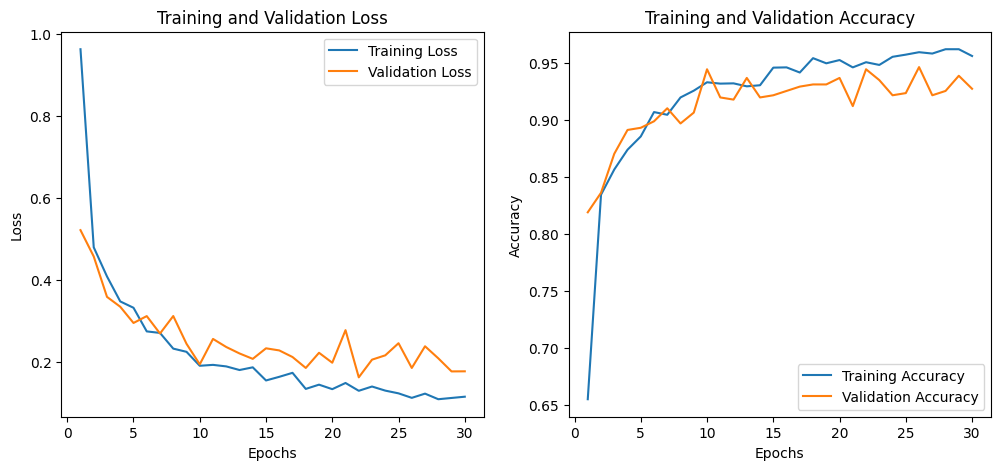

In [11]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Test Loss: 0.2189 Acc: 0.9410


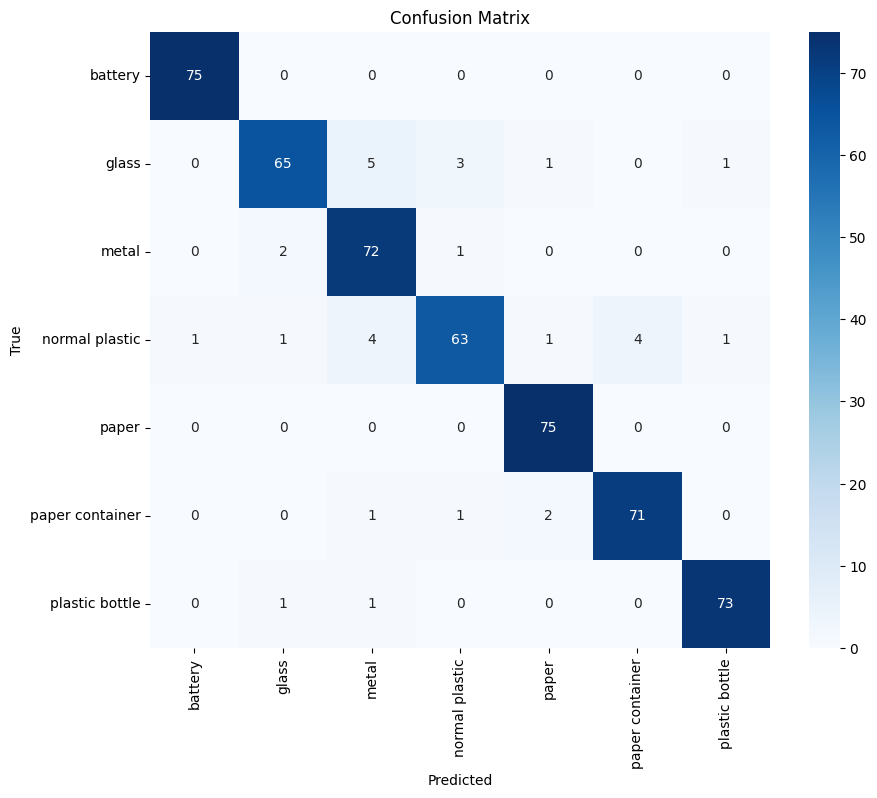


Classification Report:
                 precision    recall  f1-score   support

        battery       0.99      1.00      0.99        75
          glass       0.94      0.87      0.90        75
          metal       0.87      0.96      0.91        75
 normal plastic       0.93      0.84      0.88        75
          paper       0.95      1.00      0.97        75
paper container       0.95      0.95      0.95        75
 plastic bottle       0.97      0.97      0.97        75

       accuracy                           0.94       525
      macro avg       0.94      0.94      0.94       525
   weighted avg       0.94      0.94      0.94       525

Weighted F1 Score: 0.9404
Macro-average F1 Score: 0.9404
Micro-average F1 Score: 0.9410


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Evaluate model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {loss:.4f} Acc: {acc:.4f}')

    return all_labels, all_preds

# Evaluate on the test set
all_labels, all_preds = evaluate_model(model, dataloaders['test'])

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print('\nClassification Report:')
print(class_report)

# F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

# Macro- and Micro-average F1 Scores
macro_f1 = f1_score(all_labels, all_preds, average='macro')
micro_f1 = f1_score(all_labels, all_preds, average='micro')
print(f'Macro-average F1 Score: {macro_f1:.4f}')
print(f'Micro-average F1 Score: {micro_f1:.4f}')

In [13]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/112-2-DLA/final/vgg16.ckpt')